In [1]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, recall_score, f1_score, precision_score
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import re
import nltk
import matplotlib.pyplot as plt
from wordcloud import WordCloud

In [3]:
nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\student\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\student\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [51]:
def tokenize_comments(comments):
    stop_words = set(stopwords.words('english'))
    tokens = []
    for comment in comments:
        words = word_tokenize(comment.lower())
        filtered_words = [word for word in words if word.isalpha() and word not in stop_words]
        tokens.extend(filtered_words)
    return tokens

In [7]:
data = pd.read_csv('D:/Datasets/train.csv')

In [53]:
hate_comments = data[
    (data['toxic'] == 1) |
    (data['severe_toxic'] == 1) |
    (data['obscene'] == 1) |
    (data['threat'] == 1) |
    (data['insult'] == 1) |
    (data['identity_hate'] == 1)
]['comment_text']

good_comments = data[
    (data['toxic'] == 0) &
    (data['severe_toxic'] == 0) &
    (data['obscene'] == 0) &
    (data['threat'] == 0) &
    (data['insult'] == 0) &
    (data['identity_hate'] == 0)
]['comment_text']

hate_tokens = tokenize_comments(hate_comments)
good_tokens = tokenize_comments(good_comments)

hate_text = ' '.join(hate_tokens)
hate_wordcloud = WordCloud(
    width=800, 
    height=400, 
    background_color='white', 
    colormap='Reds', 
    max_words=100
).generate(hate_text)

good_text = ' '.join(good_tokens)
good_wordcloud = WordCloud(
    width=800, 
    height=400, 
    background_color='white', 
    colormap='Greens', 
    max_words=100
).generate(good_text)

In [55]:
data['comment_text'] = data['comment_text'].apply(preprocess_text)

In [56]:
X = data['comment_text']
y = data[['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']]

In [57]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=42)

In [58]:
vectorizer = TfidfVectorizer(max_features=10000, ngram_range=(1, 2))
X_train_tfidf = vectorizer.fit_transform(X_train)
X_valid_tfidf = vectorizer.transform(X_valid)

In [63]:
models = {}
for label in y.columns:
    print(f'Training model for {label}...')
    model = LogisticRegression(max_iter=1000, random_state=42)
    model.fit(X_train_tfidf, y_train[label])
    models[label] = model

Training model for toxic...
Training model for severe_toxic...
Training model for obscene...
Training model for threat...
Training model for insult...
Training model for identity_hate...


In [65]:
def classify_comment(comment):
    preprocessed_comment = preprocess_text(comment)
    vectorized_comment = vectorizer.transform([preprocessed_comment])
    results = {}
    for label, model in models.items():
        prediction = model.predict(vectorized_comment)[0]
        results[label] = prediction
    if any(results.values()):
        return "Harmful comment detected!", results
    else:
        return "Not a harmful comment.", results

In [67]:
metrics = {}
for label in y.columns:
    predictions = models[label].predict(X_valid_tfidf)
    accuracy = accuracy_score(y_valid[label], predictions)
    recall = recall_score(y_valid[label], predictions)
    f1 = f1_score(y_valid[label], predictions)
    precision = precision_score(y_valid[label], predictions)
    metrics[label] = {
        'accuracy_score': accuracy,
        'recall_score': recall,
        'f1_score': f1,
        'precision_score': precision
    }

In [87]:
for label, scores in metrics.items():
    print("Metrics for {}:".format(label))
    print("  Accuracy: {:.4f}".format(scores['accuracy_score']))
    print("  Recall: {:.4f}".format(scores['recall_score']))
    print("  F1 Score: {:.4f}".format(scores['f1_score']))
    print("  Precision: {:.4f}".format(scores['precision_score']))
    print("\n")

Metrics for toxic:
  Accuracy: 0.9564
  Recall: 0.6103
  F1 Score: 0.7285
  Precision: 0.9036


Metrics for severe_toxic:
  Accuracy: 0.9905
  Recall: 0.2243
  F1 Score: 0.3229
  Precision: 0.5760


Metrics for obscene:
  Accuracy: 0.9761
  Recall: 0.6187
  F1 Score: 0.7358
  Precision: 0.9076


Metrics for threat:
  Accuracy: 0.9977
  Recall: 0.1216
  F1 Score: 0.1957
  Precision: 0.5000


Metrics for insult:
  Accuracy: 0.9700
  Recall: 0.5081
  F1 Score: 0.6315
  Precision: 0.8342


Metrics for identity_hate:
  Accuracy: 0.9916
  Recall: 0.1463
  F1 Score: 0.2436
  Precision: 0.7288




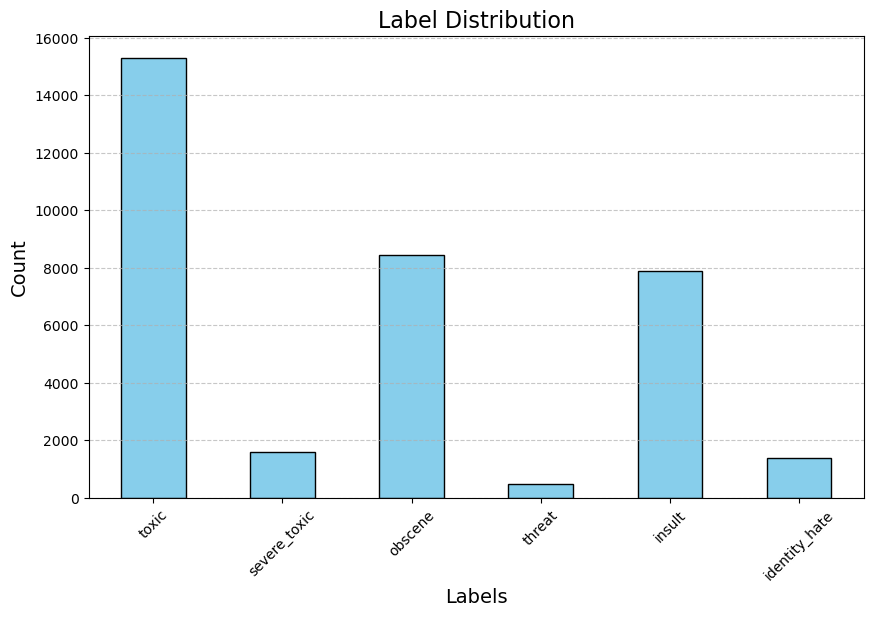

In [91]:
label_counts = y.sum()

plt.figure(figsize=(10, 6))
label_counts.plot(kind='bar', color='skyblue', edgecolor='black')
plt.title("Label Distribution", fontsize=16)
plt.xlabel("Labels", fontsize=14)
plt.ylabel("Count", fontsize=14)
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()


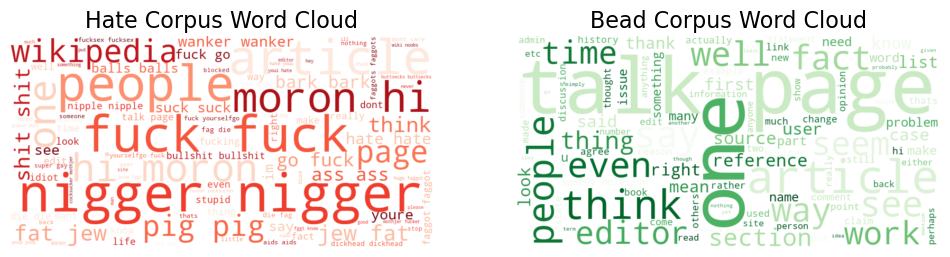

In [93]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.imshow(hate_wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title("Hate Corpus Word Cloud", fontsize=16)

plt.subplot(1, 2, 2)
plt.imshow(good_wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title("Bead Corpus Word Cloud", fontsize=16)

plt.show()


In [95]:
comment = input("Enter a comment: ")
result, detailed_results = classify_comment(comment)
print(result)
print("Detailed results:", detailed_results)

Enter a comment:  you look like a pig


Harmful comment detected!
Detailed results: {'toxic': 1, 'severe_toxic': 0, 'obscene': 0, 'threat': 0, 'insult': 0, 'identity_hate': 0}
